In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from optuna.integration import KerasPruningCallback
import lightning
from collections import deque

lightning.seed_everything(123456)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

%matplotlib inline

/home/ventus/university/data-mining/.env/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 123456


In [2]:
df = pd.read_csv("../data/mpi_saale_2021b.csv", parse_dates=['Date Time'], index_col='Date Time')["T (degC)"]

sequence_length = 30
dataset = keras.utils.timeseries_dataset_from_array(
    df.values, df.values[sequence_length:], sequence_length
)

num_samples = len(dataset)
train_size = int(0.7 * num_samples)
val_size = int(0.2 * num_samples)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

2025-04-14 01:35:12.666300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744587312.750512   13337 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744587312.771560   13337 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744587312.901948   13337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744587312.901972   13337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744587312.901976   13337 computation_placer.cc:177] computation placer alr

In [3]:
df.head()

Date Time
01.07.2021 00:10:00    15.30
01.07.2021 00:20:00    15.16
01.07.2021 00:30:00    15.18
01.07.2021 00:40:00    15.73
01.07.2021 00:50:00    16.18
Name: T (degC), dtype: float64

In [4]:
from keras import regularizers

def build_model(trial, model_type="lstm"):
    model = keras.Sequential()
    model.add(keras.Input((30,1)))
    n_layers = trial.suggest_int("n_layers", 1, 2)

    for i in range(n_layers):
        units = trial.suggest_int(f"units_layer_{i}", 32, 128, step=32)
        reg = trial.suggest_float(f"l2_reg_layer_{i}", 1e-6, 1e-2, log=True)
        return_seq = i < n_layers - 1

        if model_type == "lstm":
            model.add(keras.layers.LSTM(units, return_sequences=return_seq, kernel_regularizer=regularizers.l2(reg)))
        else:
            model.add(keras.layers.GRU(units, return_sequences=return_seq, kernel_regularizer=regularizers.l2(reg)))

        dropout = trial.suggest_float(f"dropout_layer_{i}", 0.0, 0.5)
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(1))

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model



In [5]:
from keras.callbacks import EarlyStopping

def objective(trial: optuna.Trial, model_type="lstm"):
    model = build_model(trial, model_type)

    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    pruning_cb = KerasPruningCallback(trial, monitor="val_loss")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop, pruning_cb],
        verbose=0
    )

    return min(history.history["val_loss"])

In [6]:
def make_study(name: str):
	return optuna.create_study(
		direction="minimize",
		study_name=name,
		storage="sqlite:///../data/lab4-optuna.db",
		load_if_exists=True,
		pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
	)


In [7]:
def fit_model(best_trial: optuna.Trial, model_type="lstm"):
	best_model = build_model(best_trial, model_type=model_type)
	history = best_model.fit(
		train_ds,
		validation_data=val_ds,
		callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
		epochs=30
	)
	return best_model, history

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prediction(targets, predictions):
	# Plot actual vs predicted values
	plt.figure(figsize=(12, 6))
	plt.plot(targets, label="True Values")
	plt.plot(predictions, label="Predicted Values", color="darkred")
	plt.xlabel("Time Step")
	plt.ylabel("Temperature (degC)")
	plt.title("True vs Predicted Temperature")
	plt.legend()
	plt.show()

	# Compute MAE and RMSE
	mae = mean_absolute_error(targets, predictions)
	rmse = mean_squared_error(targets, predictions)**0.5

	print(f"Mean Absolute Error (MAE): {mae}")
	print(f"Root Mean Squared Error (RMSE): {rmse}")

def evaluate_candidate(model):
	# Get model predictions for the test dataset
	test_features = np.vstack([x[0] for x in test_ds])
	test_target = np.hstack([x[1] for x in test_ds])

	# Make predictions
	test_predictions = model.predict(test_features)
	evaluate_prediction(test_target, test_predictions)

def forecast(model, horizon=30):
	x, y = next(iter(test_ds))
	targets = y[:horizon]
	sequence = deque(x[0], maxlen=sequence_length)
	for _ in range(horizon):
		pred = model.predict(
			np.reshape(sequence, (1, sequence_length, 1)),
			verbose=0,
		)
		sequence.append(pred[0,0])
	evaluate_prediction(targets.numpy(), np.array(sequence)[-horizon:])

## LSTM

In [9]:
from functools import partial
study = make_study("lstm_forecasting")
study.optimize(partial(objective, model_type="lstm"), n_trials=0, n_jobs=2)

[I 2025-04-14 01:35:15,369] Using an existing study with name 'lstm_forecasting' instead of creating a new one.


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 183.6686 - val_loss: 0.4803
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 14.4716 - val_loss: 0.3588
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 3.6129 - val_loss: 0.3144
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.8105 - val_loss: 0.2865
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.1958 - val_loss: 0.2483
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8626 - val_loss: 0.2303
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.7127 - val_loss: 0.2144
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.6249 - val_loss: 0.2000
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.5739 - val_loss: 0.1855
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.5333 - val_loss: 0.1765
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.5034 - val_loss: 0.1686
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━

2025-04-14 01:37:33.158604: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

2025-04-14 01:37:33.525390: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


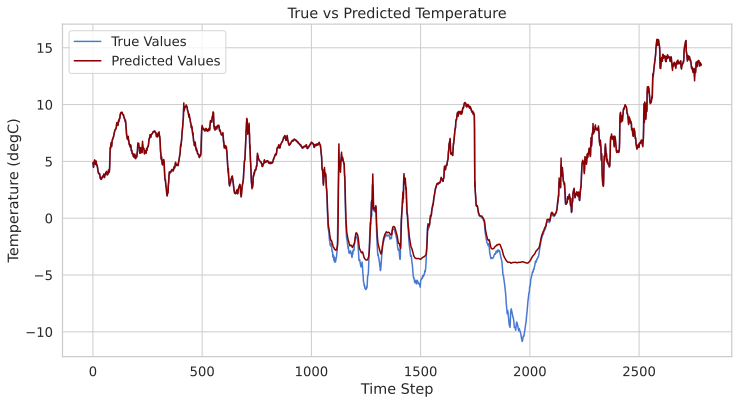

Mean Absolute Error (MAE): 0.47131879424458345
Root Mean Squared Error (RMSE): 1.1750956990835801


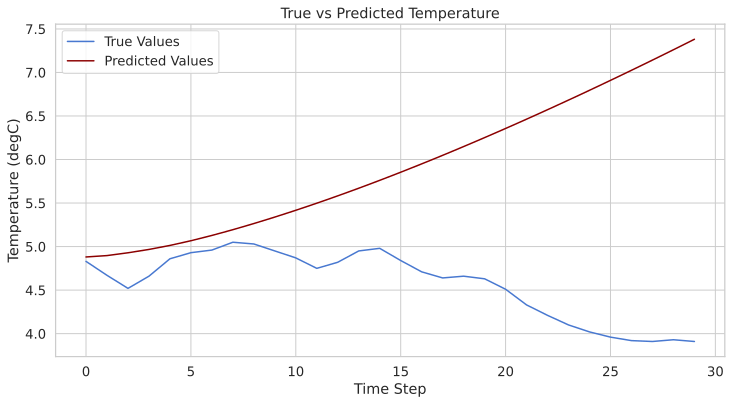

Mean Absolute Error (MAE): 1.3447585786183676
Root Mean Squared Error (RMSE): 1.7552767052226128
CPU times: user 3min 53s, sys: 1min 4s, total: 4min 57s
Wall time: 2min 20s


In [10]:
%%time
best_lstm, history = fit_model(study.best_trial, model_type="lstm")
evaluate_candidate(best_lstm)
forecast(best_lstm)

## GRU

In [11]:
from functools import partial
study = make_study("gru_forecasting")
study.optimize(partial(objective, model_type="gru"), n_trials=0, n_jobs=2)

[I 2025-04-14 01:37:36,154] Using an existing study with name 'gru_forecasting' instead of creating a new one.


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 117.1330 - val_loss: 0.4453
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 8.7076 - val_loss: 0.9645
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 2.0829 - val_loss: 0.9584
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.1222 - val_loss: 0.8504
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.8497 - val_loss: 0.7313
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.7131 - val_loss: 0.6083
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.6014 - val_loss: 0.5181
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.6433 - val_loss: 0.4811
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.5196 - val_loss: 0.4032
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.5381 - val_loss: 0.3679
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.5173 - val_loss: 0.3147
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━━

2025-04-14 01:40:27.012696: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


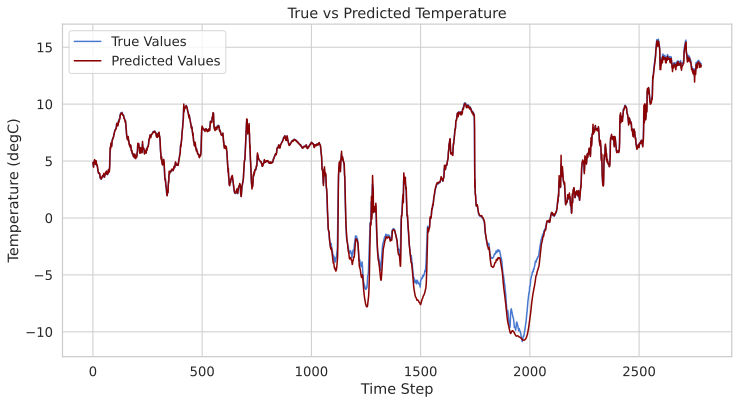

Mean Absolute Error (MAE): 0.28944970553437327
Root Mean Squared Error (RMSE): 0.5570169469055212


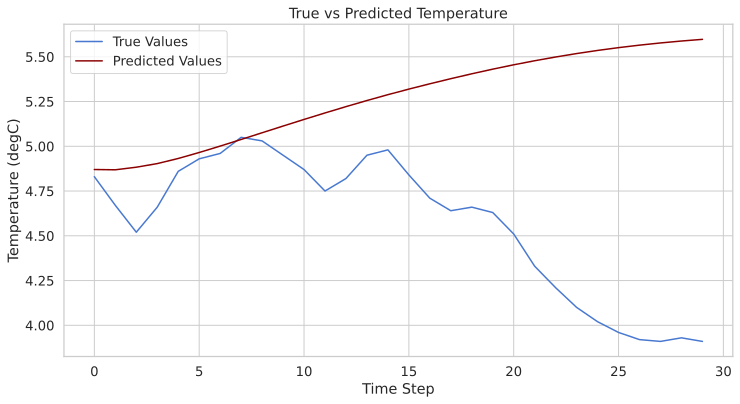

Mean Absolute Error (MAE): 0.6970422185262044
Root Mean Squared Error (RMSE): 0.913916651778277
CPU times: user 4min 27s, sys: 1min 3s, total: 5min 31s
Wall time: 2min 53s


In [12]:
%%time
best_gru, history = fit_model(study.best_trial, model_type="gru")
evaluate_candidate(best_gru)
forecast(best_gru)

## Explainer

In [168]:
from LIMESegment.Utils.explanations import LIMESegment
import matplotlib.cm as cm
import matplotlib.colors as mcolors


class Explainer:
	def __init__(self, ts):
		self.th = ts.squeeze()[-1]
		self.ts = ts

	def explain_instance(self, segments=4, background=200, **kwargs):
		norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
		cmap = cm.coolwarm
		ts = self.ts
		scores, change_points = LIMESegment(ts, self, cp=segments-1, n=background, **kwargs)

		for score, start, end in zip(scores, change_points, change_points[1:]):
			end %= len(ts)
			plt.plot(range(start, end+1), ts[start:end+1], color=cmap(norm(score)), linewidth=3)
			mid = (start + end) // 2
			plt.text(mid, ts[mid] + 0.1, f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
		plt.show()
	
	def predict(self, x):
		return best_gru.predict(x, verbose=0).squeeze() > self.th

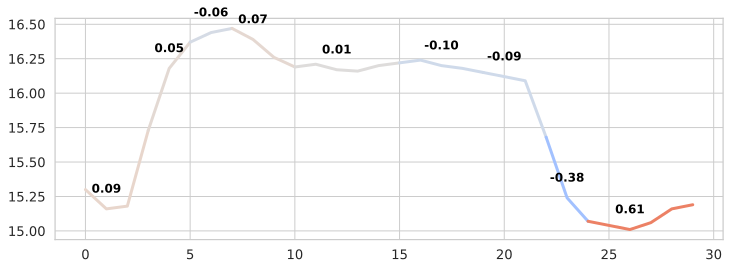

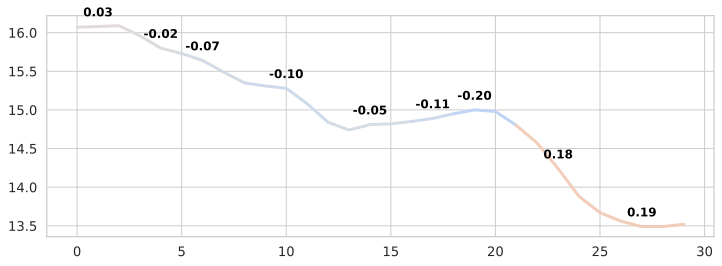

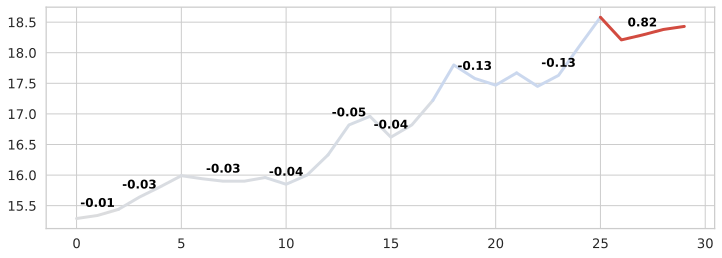

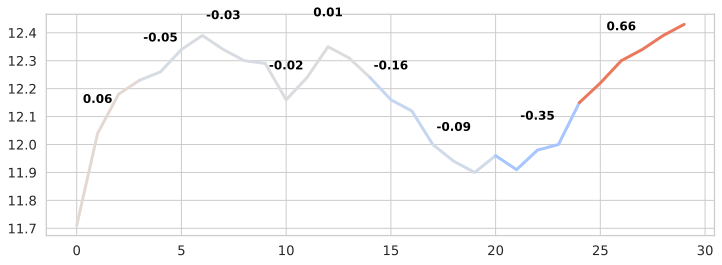

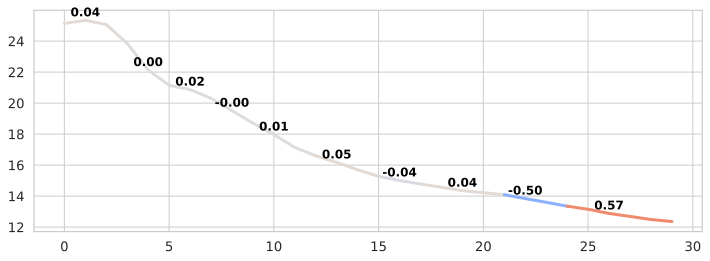

In [169]:
for interval in range(0, 500, 100):
	Explainer(df.values[interval:interval+sequence_length,None]).explain_instance(segments=10, window_size=4)